# Chapter 7: learning the best cut

In [20]:
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-paper')
plt.rc('text', usetex=False)

import warnings
warnings.filterwarnings('ignore')

# 0. Load training/validation data

In [21]:
# Training
data_tr = pd.read_csv('../../scripts/aism/dataset_12-2017/data_training.csv', header=0, index_col=0)
labels_tr = pd.read_csv('../../scripts/aism/dataset_12-2017/labels_training.csv', header=0, index_col=0)
yy = np.where(labels_tr.values == 'SP', 1, 0)  # map RR - SP / 0 - 1
labels_tr = pd.DataFrame(data=yy, index=labels_tr.index, columns=labels_tr.columns)

In [22]:
# Validation
data_vld = pd.read_csv('../../scripts/aism/dataset_12-2017/data_valid.csv', header=0, index_col=0)
labels_vld = pd.read_csv('../../scripts/aism/dataset_12-2017/labels_valid.csv', header=0, index_col=0)
yy = np.where(labels_vld.values == 'SP', 1, 0)  # map RR - SP / 0 - 1
labels_vld = pd.DataFrame(data=yy, index=labels_vld.index, columns=labels_vld.columns)

## 0.1 Load SS results

In [23]:
def load_pkl(filename):
    """Load the input pkl file."""
    with open(filename,'rb') as f:
        dd = pkl.load(f)
    return dd

# Model names
names = ['gradient_boosting', 'random_forests', 'l1l2',
        'l2_logistic_regression', 'l1_logistic_regression',
        'linear_svc_l2', 'linear_svc_l1']

tails = ['_scores', '_coefs']

scores = {}
coefs = {}

# Load the pickles
for name in names:
    scores[name] = load_pkl(os.path.join('..', '..', 'scripts', 'aism', name+tails[0]+'.pkl'))
    coefs[name] = load_pkl(os.path.join('..', '..', 'scripts', 'aism', name+tails[1]+'.pkl'))

# 1. Define models

In [24]:
from l1l2py.classification import L1L2Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

def create_pipelines():
    """Create all the models organized in a dictionary."""
    names = [
        'gradient_boosting',
        'random_forests',
        'l1l2',
        'l2_logistic_regression',
        'l1_logistic_regression',
        'linear_svc_l2',
        'linear_svc_l1',
        ]

    estimators = [
        GradientBoostingClassifier(learning_rate=0.05),
        RandomForestClassifier(),
        L1L2Classifier(),
        LogisticRegression(penalty='l2'),
        LogisticRegression(penalty='l1'),
        LinearSVC(penalty='l2'),
        LinearSVC(penalty='l1', dual=False)
        ]

    params = [
        {'predict__max_depth': map(int, np.linspace(10, 100, 15)), # gradient_boosting
         'predict__n_estimators': map(int, np.linspace(10, 500, 15)),
         'predict__max_features': ['log2', 'sqrt', 0.5, None]},
        {'predict__max_features': np.linspace(0.1, 0.9, 10),  # random_forests
         'predict__min_samples_leaf': np.arange(1, 10),
         'predict__n_estimators': [1000]},
        {'predict__alpha': np.logspace(-3, 2, 30),  # l1l2
         'predict__l1_ratio': np.linspace(1e-3, 1, 30)},
        {'predict__C': np.logspace(-3, 2, 30)},  # l2 logistic regression
        {'predict__C': np.logspace(-3, 2, 30)},  # l1 logistic regression
        {'predict__C': np.logspace(-3, 3, 15)},  # linear svc l2
        {'predict__C': np.logspace(-3, 3, 15)}  # linear svc l1
        ]

    # Create all the cross-validated pipeline objects
    pipes = {}
    for name, estimator, param in zip(names, estimators, params):
        pipe = Pipeline([['preproc', StandardScaler()],
                         ['predict', estimator]])
        pipes[name] = GridSearchCV(estimator=pipe,
                                   param_grid=param,
                                   n_jobs=-1)
    return pipes

In [25]:
models = create_pipelines()

# 2. Fit on increasingly wider training sets

In [26]:
def flatten(x):
    """Flatten a list."""
    return [y for l in x for y in flatten(l)] if type(x) in (list, np.ndarray) else [x]

In [27]:
from sklearn import metrics

def evaluate(estimator, X, y):
    """Compute the selected metrics on the input (test) set."""
    y_pred = estimator.predict(X)
    # metrics
    acc = metrics.accuracy_score(y, y_pred)
    prec = metrics.precision_score(y, y_pred)
    rcll = metrics.recall_score(y, y_pred)
    mcc = metrics.matthews_corrcoef(y, y_pred)
    return {'accuracy': acc, 'precision': prec,
            'recall': rcll, 'MCC': mcc}

In [ ]:
from collections import Counter

model_scores_trend = {} # keep track of the scores trend
for name in models.keys():
    name = 'gradient_boosting'
    print('Evaluating {} ...'.format(name))
    mdl = models[name]

    # Get the variable ranking
    c = dict(Counter(flatten([c.tolist() for c in coefs[name]])))
    c = pd.DataFrame(data=c.values(), index=c.keys(), columns=['selections'])
    ranking = c.sort_values('selections', ascending=False)

    # First divide the variables in blocks according
    # to their selection frequency (exclude features selected 0 times)
    sel_thresholds = filter(lambda x: x>0, np.unique(ranking.values))
    
    # Iterate on the thresholds and create the reduced subset of features
    metrics_thresh = {}
    for thresh in sel_thresholds:
        idx = np.where(ranking.values >= thresh)[0]  # get the indexes of the variables selected more than thresh times
        var = ranking.iloc[idx].index.tolist()  # get the actual variables list
        X, y = data_tr[var].values, labels_tr  # make the smaller X and the the y
        
        # Fit model
        mdl.fit(X, y)

        # Save each metric for the current threshold
        _metrics = evaluate(mdl, data_vld[var].values, labels_vld)
        #print('[Thresh {:2.0f}] MCC on vld: {:2.3f}'.format(thresh, _metrics['MCC']))
        metrics_thresh[thresh] = _metrics
    print('done.')
    break
    
    # Save the model scores
    model_scores_trend[name] = metrics_thresh

Evaluating gradient_boosting ...


In [11]:
# Save scores trend to disk
# with open('model_scores_trend.pkl', 'wb') as f:
#     pkl.dump(model_scores_trend, f)

In [28]:
# Load scores trend
with open('model_scores_trend.pkl', 'rb') as f:
    model_scores_trend = pkl.load(f)

In [19]:
ranking

,selections
FIM (004,1
MFIS 004,1
MFIS 006,1
MFIS 001,1
MFIS 003,1
MFIS 002,1
MFIS 009,1
MFIS 008,1
WEIG,1
HADS TOT,1


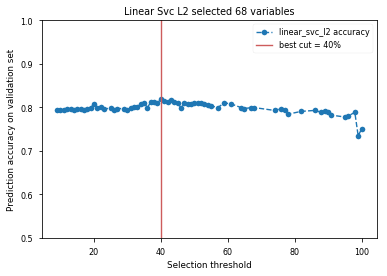

In [36]:
for name in model_scores_trend.keys():
    
    ## TODO: COMPLETE HERE
    
    best_cut = sel_thresholds[np.where(accuracies == max(accuracies))[0][-1]]
    best_cut_idx = np.where(ranking.values >= best_cut)[0]
    selected_variables = ranking.iloc[best_cut_idx].index.tolist()

    ranking.loc[selected_variables].to_csv(os.path.join('selected_variables', name+'_selected.csv'))

    plt.figure(dpi=300)
    plt.plot(sel_thresholds, accuracies, '--o', label=model+' accuracy')
    plt.axvline(best_cut, c='indianred', label='best cut = {}%'.format(best_cut))
    plt.xlabel('Selection threshold')
    plt.ylabel('Prediction accuracy on validation set')
    plt.ylim([0.5, 1.0])
    plt.legend()
    plt.tight_layout()
    plt.title(name.replace('_',' ').title()+' selected {} variables'.format(len(selected_variables)))